### Bitcoin Trader Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hiveplotlib import hive_plot_n_axes
from hiveplotlib.node import dataframe_to_node_list, split_nodes_on_variable
from hiveplotlib.viz.datashader import datashade_hive_plot_mpl

/tmp/ipykernel_3061220/1300943067.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Trading is a zero-sum game. That is, every dollar made by the person on one side of a trade is lost by the counterparty on the other side of that trade. For trades that have time delays before payments, for example, options, futures, and other more complex derivatives, there is a risk that the losing party will be unable (or unwilling) to pay the full profit to the winning party. This risk is called _counterparty risk_.

To avoid this, more common derivatives transactions are run through a _clearinghouse_. The clearinghouse acts as a counterparty to all trades, guaranteeing the profits to the winning party if the losing party falls through.

Over the Counter (OTC) trades, however, have no clearinghouse. Thus, traders in these markets are fully exposed to counterparty risk. To mitigate counterparty risk, it is important to only do business with trustworthy people. 

In this notebook, we conduct a brief exploratory analysis of a network of users rating other users by trustworthiness on an OTC Bitcoin (BTC) trading platform. From the Stanford Network Analysis Project (SNAP) website:

> "Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1."

For more, see the [SNAP website](https://snap.stanford.edu/data/soc-sign-bitcoin-otc.html).

Note: the network explored in this notebook is highly interconnected, so to see more of the nuance in our visualizations, we will opt to construct our hive plots using the `datashader` backend, which can be installed by running:

`pip install hiveplotlib[datashader]`.

For more on constructing hive plots with `datashader`, see the [Hive Plots for Large Networks notebook](https://geomdata.gitlab.io/hiveplotlib/hive_plots_for_large_networks.html).

#### The Data

To start, let's download and look at the data.

In [2]:
df = pd.read_csv(
    "https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz",
    compression="gzip",
    header=None,
    names=["source", "target", "rating", "time"],
)

df.time = pd.to_datetime(df.time * 10**9)

df.head()

source  target  rating                          time
0       6       2       4 2010-11-08 18:45:11.728359936
1       6       5       2 2010-11-08 18:45:41.533780224
2       1      15       1 2010-11-08 19:05:40.390490112
3       4       3       7 2010-11-08 19:41:17.369750016
4      13      16       8 2010-11-08 22:10:54.447459840

We are going to explore this dataset along three dimensions.

First, we will explore changes over time. We have several years worth of data (see the histogram below). Perhaps we can find anecdotal evidence of changes in trust in the network over time by looking at separate hive plots for each available year.

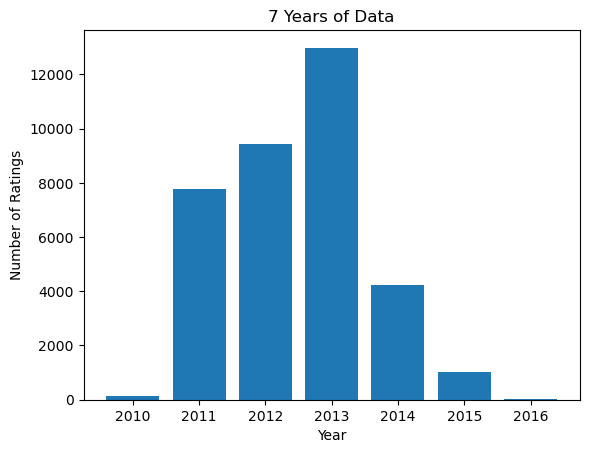

In [3]:
years = pd.DatetimeIndex(df["time"]).year
unique_years, counts = np.unique(years, return_counts=True)

fig, ax = plt.subplots()
ax.bar(unique_years, counts)
ax.set_title("7 Years of Data")
ax.set_ylabel("Number of Ratings")
ax.set_xlabel("Year")
plt.show()

2010 and 2016 have limited values, so we will exclude them in our analysis later.

In [4]:
years_to_visualize = [2011, 2012, 2013, 2014, 2015]

Our other two variables of interest will be:

- The average rating a user gives *to* others - Are there any patterns among users who are generally not trusting of others?

- The average rating a user receives _from_ others - Are there any patterns among users who are generally not trusted in the community?

#### Axes

We will build our hive plots by splitting our axes on the average rating *from* others. Specifically, we will look at:

- Negative Ratings (-10 to 0), which we will label as "Neg" in our plots.

- Low Positive Ratings (0 to 5), which we will label as "Low Pos" in our plots.

- High Positive Ratings (5 to 10), which we will label as "High Pos" in our plots.

#### Sorting on Each Axis

To sort nodes on each axis, we will place nodes based on that user's rating *to* others.

For comparability between axes, every axis min and max value will span -10 (least trustworthy) to 10 (most trustworthy), respectively.

#### Build the Hive Plots for Each Year

With all of those specifications set, we simply need to build and visualize the Hive Plots.

Rather than draw our edges and nodes one at a time, which will result in issues of oversaturation and undersaturation, we instead opt to plot the *density* of nodes and edges here. The color scales for node density and edge density are the same across all hive plots, which will allow us to compare changes in density over time in the visualization below. 

In [5]:
hps = []

# what we use to split our nodes into axes
axis_feature = "rating_from_others"

# how we place nodes along each axis
sorting_feature = "rating_to_others"

# labels for our axes
labels = ["Neg", "Low\nPos", "High\nPos"]

for year in years_to_visualize:
    # get the subnetwork for specific year
    temp_df = df.loc[years == year]

    # build our to and from rating values for each user
    target_rating = (
        temp_df.loc[:, ["target", "rating"]]
        .groupby("target")
        .mean()
        .rename(columns={"rating": "rating_from_others"})
    )
    source_rating = (
        temp_df.loc[:, ["source", "rating"]]
        .groupby("source")
        .mean()
        .rename(columns={"rating": "rating_to_others"})
    )

    ratings = target_rating.merge(source_rating, left_index=True, right_index=True)

    edges = temp_df.loc[:, ["source", "target"]].to_numpy()

    nodes = dataframe_to_node_list(ratings.reset_index(), unique_id_column="index")

    # split on [-10, 0], (0, 5], (5, 10]
    low_cutoff = 0
    high_cutoff = 5

    node_splits = split_nodes_on_variable(
        nodes,
        variable_name=axis_feature,
        cutoffs=[low_cutoff, high_cutoff],
        labels=labels,
    )

    # build the hive plot instance
    hp = hive_plot_n_axes(
        node_list=nodes,
        edges=edges,
        axes_assignments=[node_splits[label] for label in labels],
        sorting_variables=[sorting_feature] * 3,
        axes_names=labels,
        repeat_axes=[True] * 3,
        vmins=[-10, -10, -10],
        vmaxes=[10, 10, 10],
        orient_angle=-30,
    )

    hps.append(hp)

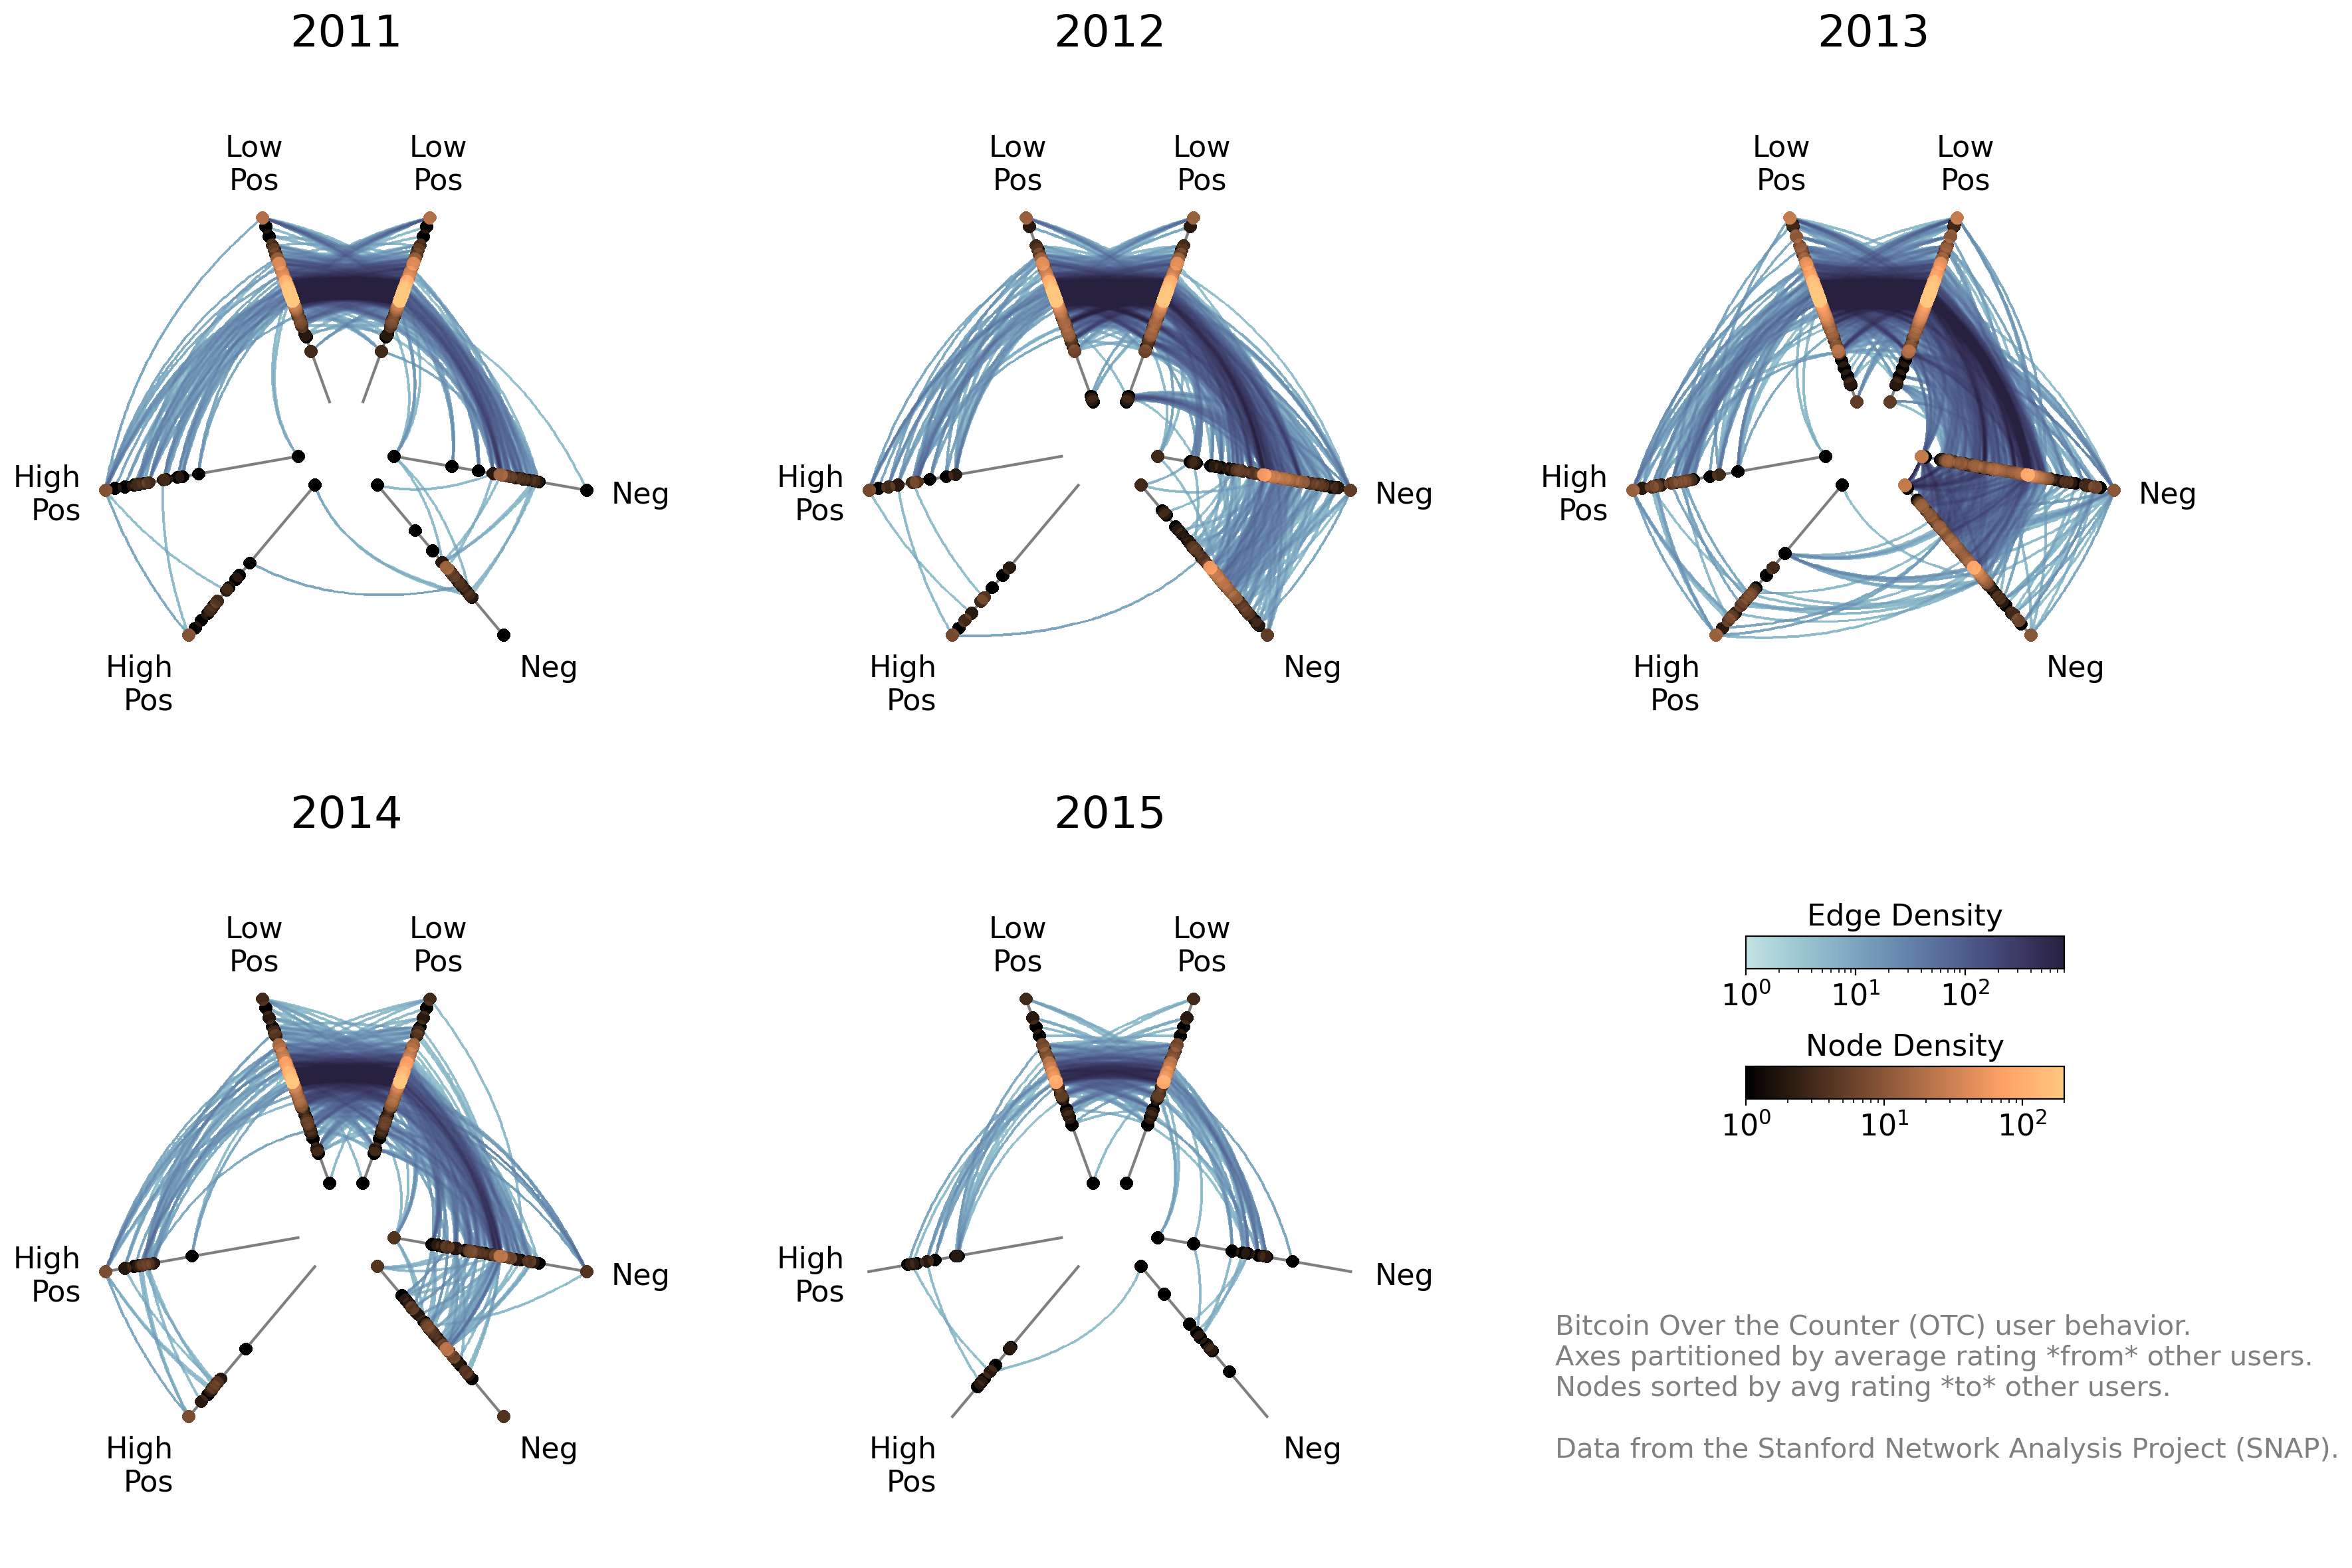

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(21, 14), dpi=200)

for i, hp in enumerate(hps):
    ax = axes.flatten()[i]
    _, _, im_nodes, im_edges = datashade_hive_plot_mpl(
        hp,
        fig=fig,
        ax=ax,
        buffer=0.3,
        axes_labels_fontsize=16,
        pixel_spread_nodes=10,
        vmax_edges=800,
        vmax_nodes=200,
    )
    ax.set_title(years_to_visualize[i], y=1.1, fontsize=24)

# clear the last axis
ax = axes.flatten()[-1]
ax.axis("off")

# colorbars for datashading nodes and edges
cax_edges = ax.inset_axes([0.3, 0.9, 0.5, 0.05], transform=ax.transAxes)
cb_edges = fig.colorbar(im_edges, ax=ax, cax=cax_edges, orientation="horizontal")
cb_edges.ax.set_title("Edge Density", size=16)
cb_edges.ax.tick_params(labelsize=16)

cax_nodes = ax.inset_axes([0.3, 0.7, 0.5, 0.05], transform=ax.transAxes)
cb_nodes = fig.colorbar(im_nodes, ax=ax, cax=cax_nodes, orientation="horizontal")
cb_nodes.ax.set_title("Node Density", size=16)
cb_nodes.ax.tick_params(labelsize=16)

ax.text(
    x=0,
    y=0.15,
    s="Bitcoin Over the Counter (OTC) user behavior.\n"
    "Axes partitioned by average rating *from* other users.\n"
    "Nodes sorted by avg rating *to* other users.\n\n"
    "Data from the Stanford Network Analysis Project (SNAP).",
    size=15,
    color="gray",
    ha="left",
    transform=ax.transAxes,
)

plt.show()

#### Anecdotal Conclusions

Of course, we can't draw any _causal_ conclusions looking at these figures, but we can pick out a few interesting narratives that could dictate further research.

##### The Number of High Positive to Negative Connections

In all of the years excluding 2013, The High Positive users minimally rate Negative users, as exemplified by the minimal (or lack of) edges between High Pos and Neg on the bottom of each hive plot.

In 2013, however, the year with the greatest activity overall on Bitcoin OTC, we see far more of these connections. Choosing to rate another user is a strong proxy for those two users choosing to do business. BTC traders were likely encouraged to trade more frequently with less fear, as the [price of BTC in dollars](https://www.tradingview.com/symbols/BTCUSD/) skyrocketed in 2013 from roughly $50 to as high as $1000 that year. In 2014, however, when BTC fell back into the $200s, High Positive-rated users went back to not rating Negative-rated users.

##### A Surge, Then Decline of Untrustworthy Interactions

The structure of the network is quite similar in 2011 and 2015 in terms of node and edge density, but starting in 2012 and peaking in 2013, we see a "surge of negativity," that is, a relative spike in the number of Negative users despite relatively consistent numbers of High Positive users. In particular, the greatest visible change is on the low end of the intra-Negative group edges. We see a spike in Negative users as rated by their peers who are negatively rating most of the users they interact with (hence they are on the low end of the Negative group axes). This abundance of low intra-Negative group edges represents a surge of mutually untrusting trading.

Furthermore, in the network as a whole in 2013, we see an increased willingness to engage with shady users, as implied by the increasing density of edges closer to the center of the hive plot. The more central an edge, the less one or both of the users trusts the average user they rate.

As mentioned above, in 2013 BTC surged in price. Over the Counter trading without trust is okay when everyone's making money. During the price collapse starting in 2014 and persisting through 2015, however, we see a drastic decline in the density of those mutually untrusting ratings&mdash;the low intra-Negative group edges. We also see the density of the edges as a whole shift away from the center of the hive plots in 2014 and 2015, implying that users in every group reverted back to interacting with more trustworthy users on average. Perhaps users got burned by counterparty risk during BTC's price collapse and changed their behavior accordingly.

#### References

J. Leskovec, A. Krevl. SNAP Datasets: Stanford Large Network Dataset Collection. http://snap.stanford.edu/data, 2014.

S. Kumar, F. Spezzano, V.S. Subrahmanian, C. Faloutsos. Edge Weight Prediction in Weighted Signed Networks. IEEE International Conference on Data Mining (ICDM), 2016.

S. Kumar, B. Hooi, D. Makhija, M. Kumar, V.S. Subrahmanian, C. Faloutsos. REV2: Fraudulent User Prediction in Rating Platforms. 11th ACM International Conference on Web Searchand Data Mining (WSDM), 2018.